Resnet34 Used as an encoder. Found from https://www.kaggle.com/iafoss/fine-tuning-resnet34-on-ship-detection

In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [8]:
PATH = './'
TRAIN = 'E:/Data/all/train_v2'
TEST = 'E:/Data/all/test_v2'
SEGMENTATION = 'E:/Data/all/train_ship_segmentations_v2.csv'
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted image

In [9]:
nw = 4   #number of workers for data loader
arch = resnet34 #specify target architecture

In [10]:
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
for el in exclude_list:
    if(el in train_names): train_names.remove(el)
    if(el in test_names): test_names.remove(el)
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)

In [11]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        if(self.path == TEST): return 0
        masks = self.segmentation_df.loc[self.fnames[i]]['EncodedPixels']
        if(type(masks) == float): return 0 #NAN - no ship 
        else: return 1
    
    def get_c(self): return 2 #number of classes

In [14]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(20, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    #md.is_multi = False
    return md

In [15]:
sz = 256 #image size
bs = 64  #batch size

md = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learn.opt_fn = optim.Adam

 66%|██████▌   | 1881/2858 [25:01<19:23,  1.19s/it, loss=0.882]

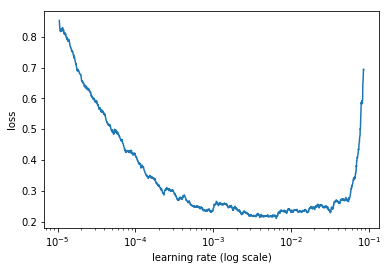

In [16]:
learn.lr_find()
learn.sched.plot()

In [17]:
learn.fit(2e-3, 1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.182155   0.139851   0.947964  


[array([0.13985]), 0.9479642708023207]

In [18]:
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])


In [19]:
learn.fit(lr, 1, cycle_len=2, use_clr=(20,8))

epoch      trn_loss   val_loss   accuracy                       
    0      0.114842   0.082409   0.971437  
    1      0.080802   0.060332   0.978292                        


[array([0.06033]), 0.978292480191602]

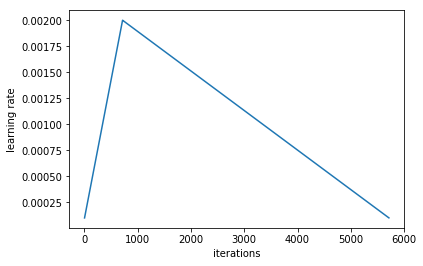

In [20]:
learn.sched.plot_lr()

In [23]:
learn.save('Resnet34_Sky_lable_256_1')

Now we train ResNet on images bigger than 256x256

In [22]:
sz = 384 #image size
bs = 32  #batch size

md = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learn.opt_fn = optim.Adam
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])

In [24]:
learn.load('Resnet34_Sky_lable_256_1')

In [25]:
learn.lr_find()

 62%|██████▏   | 3525/5716 [49:42<36:23,  1.00it/s, loss=0.692]  

In [26]:
learn.fit(lr/2, 1, cycle_len=2, use_clr=(20,8))

epoch      trn_loss   val_loss   accuracy                         
    0      0.115359   0.076386   0.971645  
    1      0.080802   0.055718   0.982032                         


[array([0.05572]), 0.9820315744998696]

In [ ]:
sz = 384 #image size
bs = 32  #batch size

md = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, md, ps=0.4) #dropout 50%
learn.opt_fn = optim.Adam
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])